In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./utils')  # or use full path if needed

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib

# For API Keys
import os
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWar

In [12]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [13]:
# PCA + Spectral
# UMAP + HDBSCAN

In [14]:
bull_tickers = ['SPY', 'TLT', 'GLD', 'VIXM', 'SPHB', 'SPLV']
df_bull_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=bull_tickers)

print(df_bull_raw.pivot(columns='symbol').isna().sum())

             symbol
open         GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
high         GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
low          GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
close        GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
volume       GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
trade_count  GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
vwap         GLD       0
             SPHB      0
             SPLV      0
     

In [15]:
# --- Configuration ---
ROLLING_WINDOW = 20  # You can adjust this

# --- Filter SPY Data ---
df_spy = df_bull_raw[df_bull_raw['symbol'] == 'SPY'].sort_index().copy()

# --- Feature 1: Trend Consistency Score ---
df_spy['trend_consistency'] = ((df_spy['close'] - df_spy['low']) / 
                                (df_spy['high'] - df_spy['low'] + 1e-6)).rolling(ROLLING_WINDOW).mean()

# --- Feature 2: Volatility Asymmetry Index ---
returns = df_spy['close'].pct_change()

def upside_vol_func(returns_window):
    pos_returns = returns_window[returns_window > 0]
    if len(pos_returns) >= 2:  # needs at least 2 points for std
        return pos_returns.std()
    else:
        return np.nan

upside_vol = returns.rolling(ROLLING_WINDOW).apply(upside_vol_func, raw=False)
total_vol = returns.rolling(ROLLING_WINDOW).std()
df_spy['vol_asymmetry'] = upside_vol / (total_vol + 1e-6)

# --- Feature 6: Higher High Consistency ---
higher_high = (df_spy['high'] > df_spy['high'].shift(1)).astype(int)
df_spy['higher_high_consistency'] = higher_high.rolling(ROLLING_WINDOW).mean()

# --- Feature 8: Volume Trend Divergence ---
df_spy['volume_trend_divergence'] = (
    df_spy['close'].pct_change().rolling(ROLLING_WINDOW)
    .corr(df_spy['volume'].rolling(ROLLING_WINDOW).mean())
)


In [16]:
# --- Helper function to extract close price of a symbol ---
def get_close(symbol):
    return df_bull_raw[df_bull_raw['symbol'] == symbol].sort_index()['close']

# Get closes for external tickers
tlt = get_close('TLT')
gld = get_close('GLD')
vixm = get_close('VIXM')
sphb = get_close('SPHB')
splv = get_close('SPLV')

# Align all external data to SPY's index
external_df = pd.DataFrame(index=df_spy.index)

# --- Feature 7: Correlations ---
external_df['spy_tlt_corr'] = df_spy['close'].pct_change().rolling(ROLLING_WINDOW).corr(tlt.pct_change())
external_df['spy_gld_corr'] = df_spy['close'].pct_change().rolling(ROLLING_WINDOW).corr(gld.pct_change())

# --- Feature 9: Implied Volatility Drift (from VIXM) ---
external_df['vixm_drift'] = vixm.pct_change().rolling(ROLLING_WINDOW).mean()

# --- Feature 10: High Beta vs. Low Volatility Spread ---
external_df['beta_vol_spread'] = sphb.pct_change().rolling(ROLLING_WINDOW).mean() - \
                                  splv.pct_change().rolling(ROLLING_WINDOW).mean()

In [17]:
# Combine SPY-only features and external features
bull_features_df = pd.concat([df_spy[['trend_consistency', 'vol_asymmetry', 
                                 'higher_high_consistency', 'volume_trend_divergence']],
                         external_df], axis=1)

# Optional: Drop rows with missing values
print(bull_features_df.isna().sum())
bull_features_df.dropna(inplace=True)

trend_consistency          19
vol_asymmetry              20
higher_high_consistency    19
volume_trend_divergence    38
spy_tlt_corr               20
spy_gld_corr               20
vixm_drift                 20
beta_vol_spread            20
dtype: int64


In [18]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]
only_bull_features_df.shape

(864, 8)

In [32]:
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import pandas as pd

# Parameters
normalize = True
n_clusters_list = [2, 3, 4]
affinities = ['rbf', 'nearest_neighbors']
n_neighbors_list = [5, 10, 15]
assign_labels_list = ['kmeans', 'discretize']
random_state = 4  # <-- Fixed

# Generate all 3-feature combinations
feature_trios = list(combinations(only_bull_features_df.columns, 3))

# Store results
results = []

for trio in tqdm(feature_trios, desc="Feature trio loop"):
    X = only_bull_features_df[list(trio)].dropna().values

    if normalize:
        X = StandardScaler().fit_transform(X)

    for n_clusters in n_clusters_list:
        for affinity in affinities:
            for assign_labels in assign_labels_list:
                if affinity == 'rbf':
                    try:
                        model = SpectralClustering(
                            n_clusters=n_clusters,
                            affinity='rbf',
                            assign_labels=assign_labels,
                            random_state=random_state
                        )
                        labels = model.fit_predict(X)
                        sil = silhouette_score(X, labels)
                        ch = calinski_harabasz_score(X, labels)
                        db = davies_bouldin_score(X, labels)

                        label_counts = pd.Series(labels).value_counts(normalize=True).sort_index()
                        cluster_proportions = tuple(round(p, 3) for p in label_counts.tolist())

                        results.append({
                            'features': trio,
                            'n_clusters': n_clusters,
                            'affinity': affinity,
                            'assign_labels': assign_labels,
                            'n_neighbors': None,
                            'random_state': random_state,
                            'silhouette': sil,
                            'calinski_harabasz': ch,
                            'davies_bouldin': db,
                            "cluster_prop": cluster_proportions
                        })
                    except:
                        continue
                else:
                    for n_neighbors in n_neighbors_list:
                        try:
                            model = SpectralClustering(
                                n_clusters=n_clusters,
                                affinity='nearest_neighbors',
                                n_neighbors=n_neighbors,
                                assign_labels=assign_labels,
                                random_state=random_state
                            )
                            labels = model.fit_predict(X)
                            sil = silhouette_score(X, labels)
                            ch = calinski_harabasz_score(X, labels)
                            db = davies_bouldin_score(X, labels)

                            label_counts = pd.Series(labels).value_counts(normalize=True).sort_index()
                            cluster_proportions = tuple(round(p, 3) for p in label_counts.tolist())

                            results.append({
                                'features': trio,
                                'n_clusters': n_clusters,
                                'affinity': affinity,
                                'assign_labels': assign_labels,
                                'n_neighbors': n_neighbors,
                                'random_state': random_state,
                                'silhouette': sil,
                                'calinski_harabasz': ch,
                                'davies_bouldin': db,
                                "cluster_prop": cluster_proportions
                            })
                        except:
                            continue

# Results DataFrame
grid_df = pd.DataFrame(results)


Feature trio loop:   2%|▏         | 1/56 [00:01<01:48,  1.97s/it]c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not

In [33]:
# Ensure full output is shown
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows (if needed)
pd.set_option('display.max_colwidth', None) # Show full column content
pd.set_option('display.width', 0)           # Prevent line wrapping

grid_df.sort_values(by='silhouette', ascending=False)\
 .reset_index(drop=True).head(30)


,features,n_clusters,affinity,assign_labels,n_neighbors,random_state,silhouette,calinski_harabasz,davies_bouldin,cluster_prop
0,"(higher_high_consistency, vixm_drift, beta_vol_spread)",2,rbf,kmeans,NaN,4,0.470852,79.695541,0.603623,"(0.984, 0.016)"
1,"(higher_high_consistency, vixm_drift, beta_vol_spread)",2,rbf,discretize,NaN,4,0.446986,113.568767,0.745114,"(0.972, 0.028)"
2,"(vol_asymmetry, volume_trend_divergence, vixm_drift)",2,nearest_neighbors,kmeans,5.0,4,0.416058,26.246632,0.553472,"(0.993, 0.007)"
3,"(vol_asymmetry, volume_trend_divergence, vixm_drift)",2,rbf,kmeans,NaN,4,0.416058,26.246632,0.553472,"(0.993, 0.007)"
4,"(vol_asymmetry, volume_trend_divergence, vixm_drift)",2,nearest_neighbors,discretize,5.0,4,0.416058,26.246632,0.553472,"(0.993, 0.007)"
5,"(vol_asymmetry, volume_trend_divergence, vixm_drift)",2,rbf,discretize,NaN,4,0.416058,26.246632,0.553472,"(0.993, 0.007)"
6,"(vol_asymmetry, spy_tlt_corr, vixm_drift)",2,rbf,discretize,NaN,4,0.406584,25.169967,0.539183,"(0.993, 0.007)"
7,"(vol_asymmetry, spy_tlt_corr, vixm_drift)",2,rbf,kmeans,NaN,4,0.406584,25.169967,0.539183,"(0.993, 0.007)"
8,"(vol_asymmetry, spy_tlt_corr, vixm_drift)",2,nearest_neighbors,kmeans,5.0,4,0.406584,25.169967,0.539183,"(0.993, 0.007)"
9,"(spy_gld_corr, vixm_drift, beta_vol_spread)",2,rbf,kmeans,NaN,4,0.404923,56.692131,0.747048,"(0.984, 0.016)"


Silhouette Score: 0.471
Calinski-Harabasz Score: 79.696
Davies-Bouldin Score: 0.604
Cluster 0 mean → higher_high_consistency: 0.04, vixm_drift: -0.03, beta_vol_spread: 0.04
Cluster 1 mean → higher_high_consistency: -2.48, vixm_drift: 1.86, beta_vol_spread: -2.41


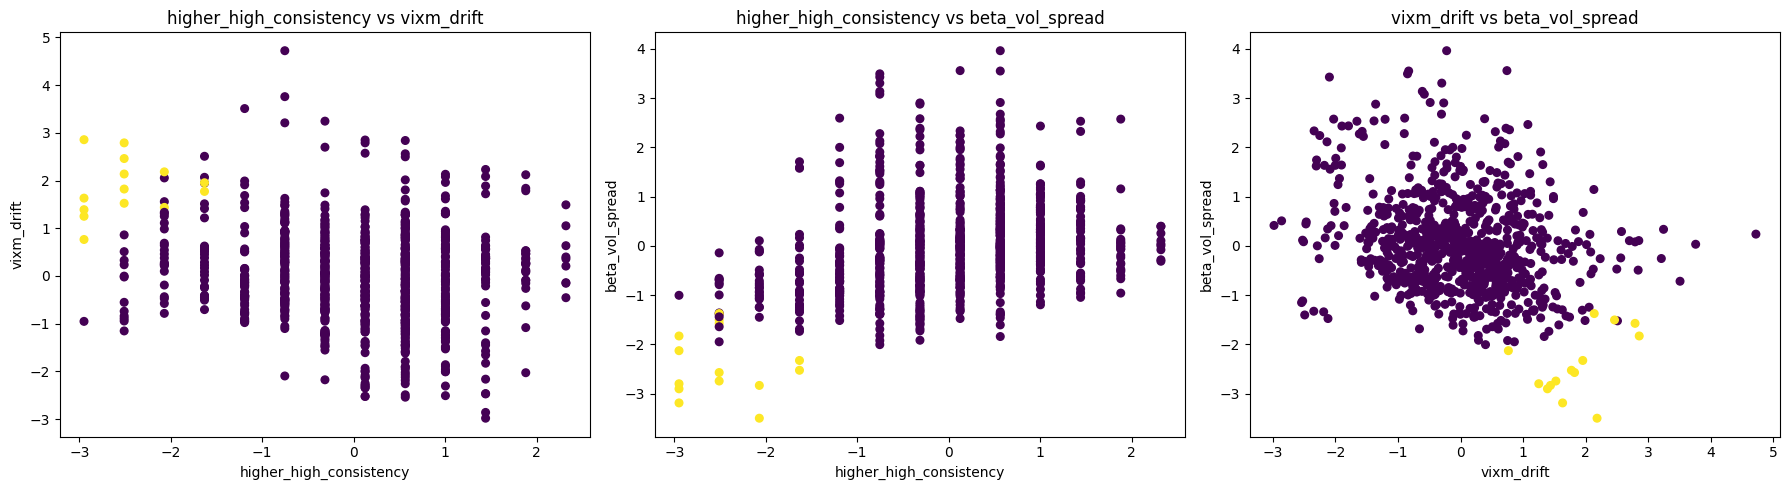

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

selected_feats = ["higher_high_consistency", "vixm_drift", "beta_vol_spread"]
# Standardize features
X = StandardScaler().fit_transform(only_bull_features_df[selected_feats].values)

# Spectral Clustering
model = SpectralClustering(
    n_clusters=2,
    affinity='rbf',
    assign_labels='kmeans',
    random_state=4
)
labels = model.fit_predict(X)

# Clustering Scores
sil = silhouette_score(X, labels)
ch = calinski_harabasz_score(X, labels)
db = davies_bouldin_score(X, labels)

print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski-Harabasz Score: {ch:.3f}")
print(f"Davies-Bouldin Score: {db:.3f}")

# Cluster Means
for cluster_id in np.unique(labels):
    cluster_mean = X[labels == cluster_id].mean(axis=0)
    mean_str = ", ".join(f"{name}: {val:.2f}" for name, val in zip(selected_feats, cluster_mean))
    print(f"Cluster {cluster_id} mean → {mean_str}")

# Scatter Plots for all feature combinations
feature_combinations = [(0, 1), (0, 2), (1, 2)]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (i, j) in zip(axes, feature_combinations):
    ax.scatter(X[:, i], X[:, j], c=labels, cmap='viridis', s=30)
    ax.set_xlabel(selected_feats[i])
    ax.set_ylabel(selected_feats[j])
    ax.set_title(f'{selected_feats[i]} vs {selected_feats[j]}')

plt.tight_layout()
plt.show()

